In [1]:
!pip install -q scikit-multilearn

try:
  %tensorflow_version 2.x
except Exception:
  print('Ahem! Ahem! Not in CoLab.')

TensorFlow 2.x selected.


In [2]:
!pip3 install bpmll
from bpmll import bp_mll_loss

In [3]:
!git clone https://git.cse.iitb.ac.in/ssood/posters-dataset.git

fatal: destination path 'posters-dataset' already exists and is not an empty directory.


In [0]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import random

import os
import cv2

import gc

import time
from datetime import timedelta

import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
print(tf.__version__)

# Prints something if GPU is connected
tf.test.gpu_device_name()

2.0.0


''

In [0]:
genres_list = [
    "Adventure",
    "Fantasy",
    "Animation",
    "Drama",
    "Horror",
    "Action",
    "Comedy",
    "History",
    "Western",
    "Thriller",
    "Crime",
    "Documentary",
    "Science Fiction",
    "Mystery",
    "Music",
    "Romance",
    "Family",
    "War",
    "Foreign",
    "TV Movie",
]
others_label = 'Others'

In [0]:
# ------ Control Center ------
path = 'posters-dataset/'
poster_shape = (268, 182, 3)
year = 1989
others_genres_flag = False
num_posters = None              # None for all images

batch_size = 100 
epochs = 15
train = True                    # True or False. False loads the model file.
bp_mll = False
english_only = True

In [0]:
def preprocess(filename, max_rows=None):
    df = pd.read_csv(filename, dtype={'imdb_id': 'str', 'genres': 'str', 'release_date': 'str', 'original_language': 'str'}, 
                     usecols=['imdb_id', 'genres', 'release_date', 'original_language'])
    
    if english_only:
      df = df[df.original_language=='en']

    # filter out all rows having no IMDB id
    # filter out all rows having no genre information
    df = df[(~df['imdb_id'].isna()) & (df['genres'] != '[]') & (~df['release_date'].isna())]
       
    # filer row with release_date > year threshold and take 'imdb_id', 'genres' columns
    df = df[df['release_date'].str[:4].astype('int16') > year][['imdb_id', 'genres']]

    X_data = []
    genre_data = []

    i = 0
    for index, row in df.iterrows():
        if i == max_rows: break
        if i % 1000 == 0 and i != 0: print(f'Loaded {i} images') 
        file = path + row['imdb_id'] + '.jpg'

        if os.path.exists(file):
            poster = cv2.imread(file)
            if poster.shape == poster_shape:
                if others_genres_flag:
                    genres = {genre['name'] if genre['name'] in genres_list else others_label for genre in eval(row['genres'])}
                else:
                    genres = {genre['name'] for genre in eval(row['genres']) if genre['name'] in genres_list}
                if genres:
                    X_data.append(poster)
                    genre_data.append(genres)
                    i += 1
            else:
                print('Problem with file:' + file)

    X_data = np.array(X_data, dtype=np.uint8)

    genre_labels = genres_list
    if others_genres_flag:
        genre_labels.append(others_label)
    mlb = MultiLabelBinarizer(classes=genre_labels)
    Y_data = mlb.fit_transform(genre_data).astype(np.float32)
    
    return X_data, Y_data

In [9]:
X_data, Y_data = preprocess('posters-dataset/movies_metadata.csv', num_posters)
X_train, Y_train, X_test, Y_test = iterative_train_test_split(X_data, Y_data, test_size = 0.15)
X_train, Y_train, X_val, Y_val = iterative_train_test_split(X_train, Y_train, test_size = 0.20)

print('-' * 66)
print('Shapes & Memory Used')
print('-' * 66)
print(X_train.shape, X_train.nbytes / 2 ** 20, "MB")
print(Y_train.shape, Y_train.nbytes / 2 ** 20, "MB")
print(X_test.shape, X_test.nbytes / 2 ** 20, "MB")
print(Y_test.shape, Y_test.nbytes / 2 ** 20, "MB")

Loaded 1000 images
Loaded 2000 images
Loaded 3000 images
Loaded 4000 images
Loaded 5000 images
Loaded 6000 images
Loaded 7000 images
Loaded 8000 images
Problem with file:posters-dataset/tt1354556.jpg
Loaded 9000 images
Loaded 10000 images
Loaded 11000 images
Loaded 12000 images
Problem with file:posters-dataset/tt1534017.jpg
Loaded 13000 images
Loaded 14000 images
Loaded 15000 images
Problem with file:posters-dataset/tt1789697.jpg
Loaded 16000 images
Loaded 17000 images
Loaded 18000 images
------------------------------------------------------------------
Shapes & Memory Used
------------------------------------------------------------------
(12827, 268, 182, 3) 1789.9982986450195 MB
(12827, 20) 0.9786224365234375 MB
(2917, 268, 182, 3) 407.06517791748047 MB
(2917, 20) 0.2225494384765625 MB


In [0]:
tf.random.set_seed(7)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, use_bias=True, 
                                 kernel_initializer='glorot_normal', input_shape=poster_shape, 
                                 padding='VALID', activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))
model.add(tf.keras.layers.Dropout(0.25))

for _ in range(8):
  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, use_bias=True, 
                                   kernel_initializer='glorot_normal', padding='VALID',
                                   activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=1))
  model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, use_bias=True, kernel_initializer='glorot_normal', activation='relu'))
model.add(tf.keras.layers.Dense(Y_train.shape[1], activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 267, 181, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 133, 90, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 133, 90, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 132, 89, 32)       8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 131, 88, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131, 88, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 87, 32)       4

In [0]:
if bp_mll:
  model.compile(optimizer='adagrad', loss=bp_mll_loss, metrics=['accuracy'])
else:
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'categorical_accuracy'])

In [13]:
history = None
if train:
  start = time.time()
  history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,
                      shuffle = True, validation_data=(X_val, Y_val))
  end = time.time()
  print(f'Training Time: {timedelta(seconds=end-start)}')
  model.save('CNN_final.h5', overwrite=True)
else:
  model = tf.keras.models.load_model('CNN_final.h5')

Train on 12827 samples, validate on 3248 samples
Epoch 1/15
12827/12827 [==============================] - 369s 29ms/sample - loss: 70.5738 - accuracy: 0.8777 - categorical_accuracy: 0.3509 - val_loss: 0.6802 - val_accuracy: 0.5716 - val_categorical_accuracy: 0.0567
Epoch 2/15
12827/12827 [==============================] - 362s 28ms/sample - loss: 0.3583 - accuracy: 0.8884 - categorical_accuracy: 0.3841 - val_loss: 0.6486 - val_accuracy: 0.6463 - val_categorical_accuracy: 0.0567
Epoch 3/15
12827/12827 [==============================] - 365s 28ms/sample - loss: 0.3330 - accuracy: 0.8908 - categorical_accuracy: 0.3857 - val_loss: 0.4682 - val_accuracy: 0.8836 - val_categorical_accuracy: 0.3805
Epoch 4/15
12827/12827 [==============================] - 355s 28ms/sample - loss: 0.3124 - accuracy: 0.8916 - categorical_accuracy: 0.3824 - val_loss: 0.4252 - val_accuracy: 0.8919 - val_categorical_accuracy: 0.3464
Epoch 5/15
12827/12827 [==============================] - 361s 28ms/sample - loss:

In [0]:
predictions = {}
predictions['train'] = model.predict(np.array(X_train, dtype=np.float32))
predictions['test'] = model.predict(np.array(X_test, dtype=np.float32))

In [0]:
genres_list = np.array(genres_list)

def accuracy_3(y_true, y_pred):
  # Accuracy for predictions with highest confidence (y_pred intersection y_true)/(y_pred union y_true)
  # y_pred is list of list of floats, while y_true is one hot encoded genres
  accuracy = 0
  
  for i in range(len(y_pred)):
    top_3_indices = y_pred[i].argsort()[-3:]                   # will return indices of top 3 predictions
    pred = np.zeros(len(genres_list))
    pred[top_3_indices] =  1
    
    num = np.dot(pred, y_true[i])
    denum = np.logical_or(pred, y_true[i]).sum()
    accuracy += num / denum
    
  return accuracy / len(y_pred)

In [0]:
def accuracy(y_true, y_pred):
  # (y_pred intersection y_true)/(y_pred union y_true)
  accuracy = 0
  for i in range(len(y_pred)):
    pred = np.rint(y_pred[i])
    numerator = np.sum(pred * y_true[i])
    denominator = np.logical_or(pred, y_true[i]).sum()
    accuracy += numerator / denominator
    
  return accuracy / len(y_pred)

In [0]:
def precision(y_true, y_pred):
  # (y_pred intersection y_true)/(y_pred)
  precision = 0
  for i in range(len(y_pred)):
    pred = np.rint(y_pred[i])
    numerator = np.sum(pred * y_true[i])
    if pred.sum() != 0:
      denominator = pred.sum()
      precision += numerator / denominator 
    
  return precision / len(y_pred)

In [0]:
def recall(y_true, y_pred):
  # (y_pred intersection y_true)/(y_true)
  recall = 0
  for i in range(len(y_pred)):
    pred = np.rint(y_pred[i])
    numerator = np.sum(pred * y_true[i])
    denominator = y_true[i].sum()
    recall += numerator / denominator
    
  return recall / len(y_pred)

In [60]:
print('-' * 66)
print('Test Area')
print('-' * 66)

print(f'Accuracy_3 (Train): {accuracy_3(Y_train, predictions["train"]) * 100}')
print(f'Accuracy_3 (Test): {accuracy_3(Y_test, predictions["test"]) * 100}')

print(f'Accuracy (Train): {accuracy(Y_train, predictions["train"]) * 100}')
print(f'Accuracy (Test): {accuracy(Y_test, predictions["test"]) * 100}')

print(f'Precision (Train): {precision(Y_train, predictions["train"]) * 100}')
print(f'Precision (Test): {precision(Y_test, predictions["test"]) * 100}')

print(f'Recall (Train): {recall(Y_train, predictions["train"]) * 100}')
print(f'Recall (Test): {recall(Y_test, predictions["test"]) * 100}')

print('-' * 66)

------------------------------------------------------------------
Test Area
------------------------------------------------------------------
Accuracy_3 (Train): 22.693512320861135
Accuracy_3 (Test): 21.96295933525978
Accuracy (Train): 21.689321631825905
Accuracy (Test): 21.51786734577271
Precision (Train): 42.20004677633117
Precision (Test): 40.93246486115872
Recall (Train): 21.689321759281114
Recall (Test): 21.517867466481448
------------------------------------------------------------------


In [0]:
random.seed(7)

In [0]:
def predict_random_samples(X, Y, predictions, num_samples=10, verbose=False):
  for _ in range(num_samples):
    sample_num = random.randint(0, X.shape[0] - 1)

    y_true = Y[sample_num].astype(np.int8)
    y_pred = np.rint(predictions[sample_num].flatten()).astype(np.int8)
    # prediction = model.predict(np.array([X[sample_num]], dtype=np.float32))
    plt.figure()
    plt.imshow(X[sample_num])
    
    print('True Labels')
    print(genres_list[y_true==1])
    print('Predicted Labels')
    print(genres_list[y_pred==1])
    
    if verbose:
      print('True Values')
      print(y_true)
      print('Predicted Values')
      print(y_pred)

    if num_samples != 1:
      print('-' * 66)

Test Datapoint
------------------------------
True Labels
['Drama' 'Thriller']
Predicted Labels
['Drama']


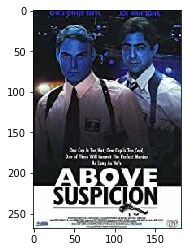

In [63]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X_test, Y_test, predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Drama' 'Comedy']
Predicted Labels
['Drama']


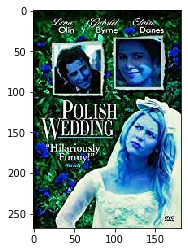

In [64]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X_test, Y_test, predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Animation' 'Comedy' 'Family']
Predicted Labels
['Drama']


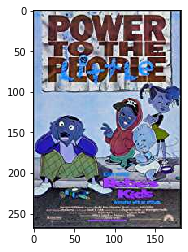

In [65]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X_test, Y_test, predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Animation' 'Drama']
Predicted Labels
['Drama']


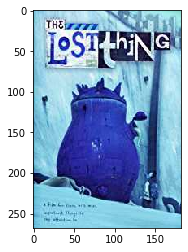

In [66]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X_test, Y_test, predictions['test'], num_samples=1)

Test Datapoint
------------------------------
True Labels
['Comedy' 'Crime' 'Family']
Predicted Labels
['Drama']


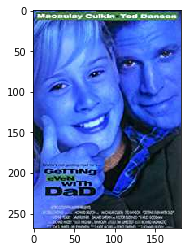

In [67]:
print('Test Datapoint')
print('-' * 30)
predict_random_samples(X_test, Y_test, predictions['test'], num_samples=1)

Train Datapoint
------------------------------------------------------------------
True Labels
['Drama']
Predicted Labels
['Drama']


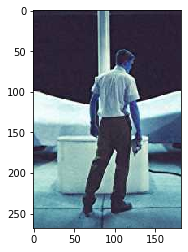

In [68]:
print('Train Datapoint')
print('-' * 66)
predict_random_samples(X_train, Y_train, predictions['train'], num_samples=1)

Train Datapoint
------------------------------------------------------------------
True Labels
['Documentary']
Predicted Labels
['Drama']


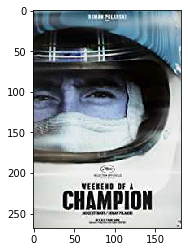

In [69]:
print('Train Datapoint')
print('-' * 66)
predict_random_samples(X_train, Y_train, predictions['train'], num_samples=1)

Train Datapoint
------------------------------------------------------------------
True Labels
['Adventure' 'Drama']
Predicted Labels
['Drama']


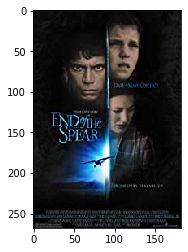

In [70]:
print('Train Datapoint')
print('-' * 66)
predict_random_samples(X_train, Y_train, predictions['train'], num_samples=1)

Train Datapoint
------------------------------------------------------------------
True Labels
['Adventure' 'Drama' 'Action' 'History' 'War']
Predicted Labels
['Drama']


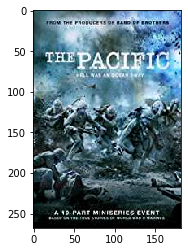

In [71]:
print('Train Datapoint')
print('-' * 66)
predict_random_samples(X_train, Y_train, predictions['train'], num_samples=1)

Train Datapoint
------------------------------------------------------------------
True Labels
['Drama']
Predicted Labels
['Drama']


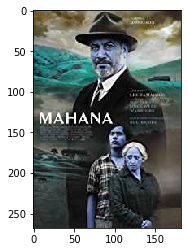

In [72]:
print('Train Datapoint')
print('-' * 66)
predict_random_samples(X_train, Y_train, predictions['train'], num_samples=1)

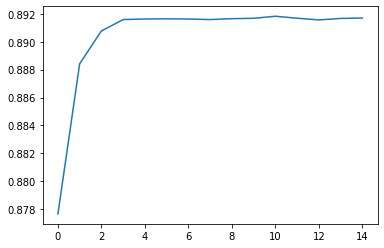

In [73]:
plt.plot(history.history['accuracy'])

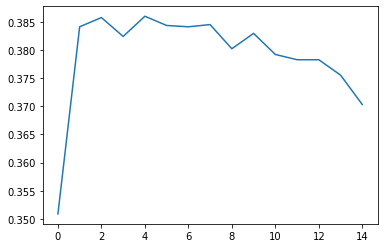

In [74]:
plt.plot(history.history['categorical_accuracy'])

Text(0, 0.5, 'Binary Cross-Entropy Loss')

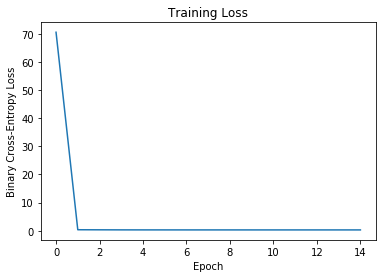

In [76]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')